# 2.1 Instruction Formatting Part 2
This is due to my local machine not being able to download unsloth, hence, this notebook was done on kaggle and imported to my local for formatting

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None 
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 6.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None, 
)

Unsloth 2025.6.2 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


# Data Prep

In [15]:
df = pd.read_csv("../input/combined-data/combined_data.csv")

df.head()

def convert_convo(df):
    conversations = []
    
    for _, row in df.iterrows():
        conversation = [
            {"from": "human", "value": row['user_msg']},
            {"from": "gpt", "value": row['output']}
        ]
        conversations.append(conversation)
    
    return pd.DataFrame({'conversations': conversations})

df = convert_convo(df)
df.head()

,conversations
0,"[{'from': 'human', 'value': '""về trễ ."" Phân l..."
1,"[{'from': 'human', 'value': '""US Stocks Rise, ..."
2,"[{'from': 'human', 'value': '""cần đa dạng hóa ..."
3,"[{'from': 'human', 'value': '""The smart money ..."
4,"[{'from': 'human', 'value': '""nội dung môn học..."


In [16]:
from datasets import load_dataset, Dataset
from unsloth.chat_templates import get_chat_template
import pandas as pd


tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def format_prompts(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

dataset = Dataset.from_pandas(df)
print(dataset)


Dataset({
    features: ['conversations'],
    num_rows: 6500
})


In [17]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(format_prompts, batched = True,)

Unsloth: Standardizing formats (num_proc=4):   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

In [18]:
dataset[5]["text"]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"Netflix Inc on Tuesday announced a multi-film deal with Japan\'s Studio Colorido, as the streaming giant ramps up its anime offering and looks to Asia for growth." What is the sentiment of this news? Please choose an answer from {strong negative/moderately negative/mildly negative/neutral/mildly positive/moderately positive/strong positive}.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\npositive<|eot_id|>'

# Training

In [19]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = False,
        bf16 = False,
        logging_steps = 1,
        optim = "adamw_torch",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/6500 [00:00<?, ? examples/s]

In [20]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=4):   0%|          | 0/6500 [00:00<?, ? examples/s]

In [21]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"Netflix Inc on Tuesday announced a multi-film deal with Japan\'s Studio Colorido, as the streaming giant ramps up its anime offering and looks to Asia for growth." What is the sentiment of this news? Please choose an answer from {strong negative/moderately negative/mildly negative/neutral/mildly positive/moderately positive/strong positive}.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\npositive<|eot_id|>'

In [22]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                            positive<|eot_id|>'

In [23]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 6,500 | Num Epochs = 1 | Total steps = 406
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


Step,Training Loss
1,6.598300
2,7.136900
3,6.301800
4,3.826600
5,1.621600
6,0.831000
7,0.680100
8,0.527900
9,0.471900
10,0.277500


Unsloth: Will smartly offload gradients to save VRAM!


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


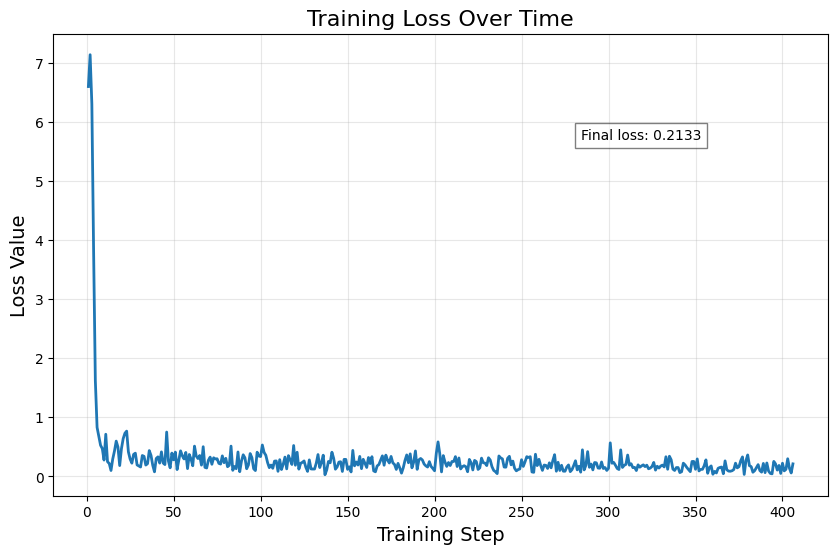

Final training loss: 0.2133


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Extract the loss values from the trainer's state
# The loss values are stored in trainer's state, not in trainer_stats
loss_values = trainer.state.log_history
loss_df = pd.DataFrame(loss_values)

# Filter only training loss entries (not eval)
loss_df = loss_df[loss_df['loss'].notna()]

# Set up the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=loss_df, x='step', y='loss', linewidth=2)

# Add labels and title
plt.title('Training Loss Over Time', fontsize=16)
plt.xlabel('Training Step', fontsize=14)
plt.ylabel('Loss Value', fontsize=14)
plt.grid(True, alpha=0.3)

# Add info about final loss
final_loss = loss_df['loss'].iloc[-1]
plt.text(loss_df['step'].max() * 0.7, loss_df['loss'].max() * 0.8, 
         f'Final loss: {final_loss:.4f}', 
         bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.show()

print(f"Final training loss: {final_loss:.4f}")

In [26]:
# Save the model and tokenizer
trainer.save_model("llama-3.2-1b-finetuned")
tokenizer.save_pretrained("llama-3.2-1b-finetuned")

('llama-3.2-1b-finetuned/tokenizer_config.json',
 'llama-3.2-1b-finetuned/special_tokens_map.json',
 'llama-3.2-1b-finetuned/tokenizer.json')